# Computing Collective Variables of the NTK

In this notebook we will walkthrough the computation of collective variables of the Neural Tangent Kernel (NTK) during training a model. 

### Imports

For calculating the NTK, we will exclusively be using the neural tangents library.

In [10]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import znnl as nl
from neural_tangents import stax
import optax

import matplotlib.pyplot as plt
import jax.numpy as np
import pandas as pd
from flax import linen as nn
import numpy as onp
import copy
from jax.scipy.linalg import polar

import jax
jax.default_backend()


'gpu'

### Data generators

For the sake of covereage, we will look at the NTK properties of the Fuel data set for a small model.

In [2]:
data_generator = nl.data.MNISTGenerator(200)

2023-10-19 17:31:12.688843: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
# class ProductionModuleConv(nn.Module):
#     """
#     Simple CNN module.
#     """

#     @nn.compact
#     def __call__(self, x):
#         x = nn.Conv(features=32, kernel_size=(3, 3))(x)
#         x = nn.relu(x)
#         x = nn.max_pool(x, window_shape=(3, 3), strides=(2, 2))
#         x = nn.Conv(features=32, kernel_size=(3, 3))(x)
#         x = nn.relu(x)
#         x = nn.max_pool(x, window_shape=(3, 3), strides=(2, 2))
#         x = x.reshape((x.shape[0], -1))  # flatten
#         x = nn.Dense(features=32)(x)
#         x = nn.relu(x)
#         x = nn.Dense(10)(x)

#         return x
    

# class ProductionModuleDense(nn.Module):
#     """
#     Simple CNN module.
#     """

#     @nn.compact
#     def __call__(self, x):
#         x = x.reshape((x.shape[0], -1))  # flatten
#         x = nn.Dense(features=128)(x)
#         x = nn.relu(x)
#         x = nn.Dense(features=128)(x)
#         x = nn.relu(x)
#         x = nn.Dense(10)(x)

#         return x
    
# model = nl.models.FlaxModel(
#             flax_module=ProductionModuleDense(),
#             optimizer=optax.adam(learning_rate=0.005),
#             input_shape=(1, 28, 28, 1),
#             batch_size=10,
#         )

In [4]:
architecture = stax.serial(
    stax.Flatten(),
    stax.Dense(128, b_std=0.05, parameterization='standard'),
    stax.Relu(),
    stax.Dense(128, b_std=0.05, parameterization='standard'),
    stax.Relu(),
    stax.Dense(10, b_std=0.05, parameterization='standard'),
)

architecture_ntk = stax.serial(
    stax.Flatten(),
    stax.Dense(128),
    stax.Relu(),
    stax.Dense(128),
    stax.Relu(),
    stax.Dense(10),
)

model = nl.models.NTModel(
    nt_module=architecture,
    optimizer=optax.sgd(learning_rate=0.001),
    # optimizer=optax.adam(learning_rate=0.01),
    input_shape=(1, 28, 28, 1),
    batch_size=10,
)


### Recording 

Using a recorder we can track the NTK and its properties while training a model. 
Defining a recorder, we can decide which properties to track. 
We will calculate 
- Loss
- Accuracy
- NTK
- Entropy of the NTK
- Trace of the NTK
- Frobenius norm of the Loss Derivative

of the train data and the Loss and Accuracy of the test data. 

In [5]:
train_recorder = nl.training_recording.JaxRecorder(
    name="train_recorder",
    loss=True,
    accuracy=True,
    ntk=True,
    covariance_entropy=True,
    covariance_ntk=True, 
    magnitude_variance=True, 
    trace=True,
    entropy=True, 
    loss_derivative=True,
    update_rate=1, 
    chunk_size=1e8,
)
train_recorder.instantiate_recorder(
    data_set=data_generator.train_ds
)


test_recorder = nl.training_recording.JaxRecorder(
    name="test_recorder",
    loss=True,
    accuracy=True,
    update_rate=1,
    chunk_size=1e8,
)
test_recorder.instantiate_recorder(
    data_set=data_generator.test_ds
)

### Training strategy 

In order to train, we need a training strategy, which will use the defined recorders. 

In [6]:
training_strategy = nl.training_strategies.SimpleTraining(
    model=model, 
    loss_fn=nl.loss_functions.CrossEntropyLoss(),
    accuracy_fn=nl.accuracy_functions.LabelAccuracy(),
    recorders=[train_recorder, test_recorder],
)

### Training

Now we train the model

In [7]:
batched_training_metrics = training_strategy.train_model(
    train_ds=data_generator.train_ds, 
    test_ds=data_generator.test_ds,
    batch_size=32,
    epochs=1000,
    seed=0,
)

  0%|                                                                   | 0/1000 [00:00<?, ?batch/s]

Epoch: 1000: 100%|████████████████████████████| 1000/1000 [12:33<00:00,  1.33batch/s, accuracy=0.84]


In [8]:
train_report = train_recorder.gather_recording()
test_report = test_recorder.gather_recording()

# Compute $\Delta$ NTK

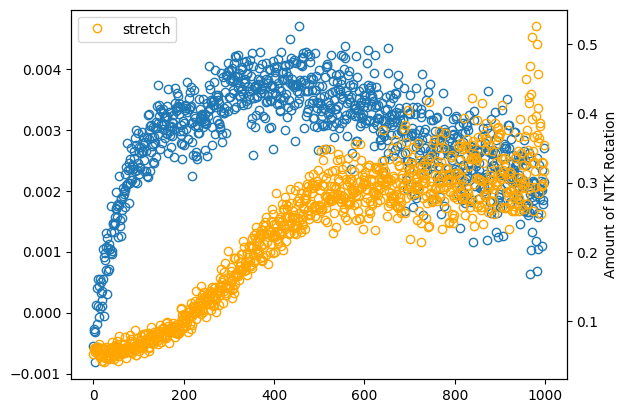

In [11]:
ntk_sequence = train_report.ntk

delta_ntk = np.array([ntk_sequence[i + 1] - ntk_sequence[i] for i in range(len(ntk_sequence)-1)])

polar_decomposed = np.array([polar(i) for i in delta_ntk])
rot_eigvals = np.array([onp.linalg.eig(p[0])[0] for p in polar_decomposed])
angle_eigvals = np.array([(np.arccos(i) - 1) / 2 for i in rot_eigvals])

plt.plot(
    np.array([p.mean() for p in polar_decomposed[:, 0]]), 
    'o', 
    mfc='None', 
    label="rotation"
)
axs2 = plt.twinx()
axs2.plot(
    np.array([p.mean() for p in polar_decomposed[:, 1]]), 
    'o', 
    mfc='None', 
    label="stretch", 
    color='orange' 
)

plt.xlabel("Epoch")
plt.ylabel("Amount of NTK Rotation")
plt.legend()
plt.show()

# Compute the rotation of the NTK transformation matrix $T$

$$ T_{i} = \Lambda_{i}^{-1} \Lambda_{i+1} $$

From that, compute the rotation of the NTK difference. 

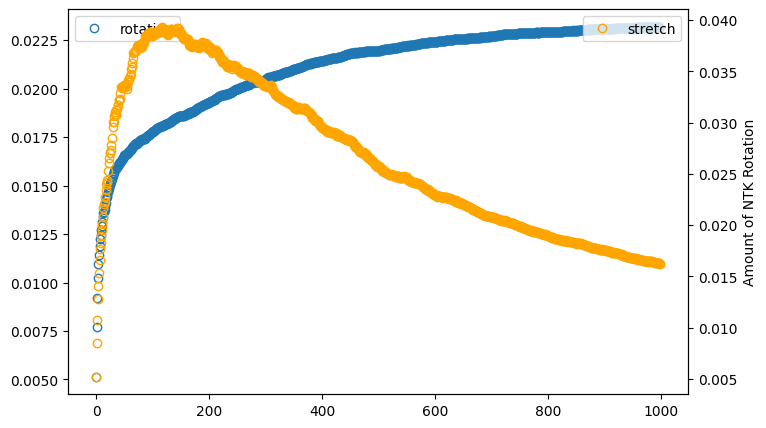

In [12]:
# Compute the tranformation matrix from each NTK to its next NTK
ntk_sequence = train_report.ntk
ntk_inv = np.array([np.linalg.inv(ntk) for ntk in ntk_sequence])

# transformation = np.array([np.dot(ntk_inv[i], ntk_sequence[i+1]) for i in range(len(ntk_sequence)-1)])
# transformation = np.array([np.dot(ntk_sequence[i], ntk_inv[0]) for i in range(len(ntk_sequence)-1)])
transformation = np.array([np.dot(ntk_sequence[0], ntk_inv[i]) for i in range(len(ntk_sequence)-1)])


# Compute the polar decomposition of each transformation matrix
polar_decomposed = np.array([polar(i) for i in transformation])


rot_eigvals = np.array([onp.linalg.eig(p[0])[0] for p in polar_decomposed])
angle_eigvals = np.array([(np.arccos(i) - 1) / 2 for i in rot_eigvals])

fix, axs = plt.subplots(1, figsize=(8, 5))
axs.plot(
    np.array([np.abs(p).mean() for p in polar_decomposed[:, 0]]), 
    'o', 
    mfc='None', 
    label="rotation"
)
axs2= plt.twinx()
axs2.plot(
    np.array([np.abs(p).mean() for p in polar_decomposed[:, 1]]), 
    'o', 
    mfc='None', 
    label="stretch", 
    color='orange'
)

plt.xlabel("Epoch")
plt.ylabel("Amount of NTK Rotation")
# Plot legend of both plots
axs.legend()
axs2.legend()
plt.show()

In [13]:
# Calculate the average 
transformation = np.array([np.dot(ntk_sequence[i], ntk_inv[0]) for i in range(len(ntk_sequence)-1)])
transformation_2 = np.array([np.dot(ntk_sequence[0], ntk_inv[i]) for i in range(len(ntk_sequence)-1)])
transformation_delta = np.array([np.dot(ntk_inv[i], ntk_sequence[i+1]) for i in range(len(ntk_sequence)-1)])

# Compute the polar decomposition of each transformation matrix
polar_decomposed = np.array([polar(i) for i in transformation])
polar_decomposed_2 = np.array([polar(i) for i in transformation_2])
polar_decomposed_delta = np.array([polar(i) for i in transformation_delta])

phases = [np.angle(onp.linalg.eig(rot_matrix)[0]) for rot_matrix in polar_decomposed[:, 0]]
phases_avg = np.abs(np.array(phases)).mean(axis=1)
phases_2 = [np.angle(onp.linalg.eig(rot_matrix)[0]) for rot_matrix in polar_decomposed_2[:, 0]]
phases_avg_2 = np.abs(np.array(phases_2)).mean(axis=1)
phases_delta = [np.angle(onp.linalg.eig(rot_matrix)[0]) for rot_matrix in polar_decomposed_delta[:, 0]]
phases_avg_delta = np.abs(np.array(phases_delta)).mean(axis=1)

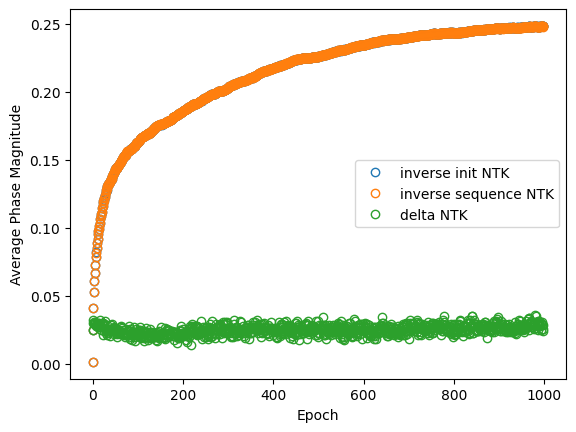

In [41]:
plt.plot(phases_avg, 'o', mfc='None', label="inverse init NTK")
plt.plot(phases_avg_2, 'o', mfc='None', label="inverse sequence NTK")
plt.plot(phases_avg_delta, 'o', mfc='None', label="delta NTK")
plt.xlabel("Epoch")
plt.ylabel("Average Phase Magnitude")
plt.legend()
plt.show()


In [15]:
# Test whether the inverse is correct
next_ntk = np.array([np.dot(ntk_sequence[i], transform) for i, transform in enumerate(transformation)])
noise = next_ntk - ntk_sequence[1:]
signal_to_noise_inverse = np.sum(ntk_sequence[:-1]**2) / np.sum(noise**2)
signal_to_noise_inverse

Array(3.6228135e-05, dtype=float32)

In [16]:
# Test whether the polar decomposition is correct
test_decomposed = np.array([np.dot(p[0], p[1]) for p in polar_decomposed])
signal_to_noise_decomposition = np.sum(transformation) / np.sum(test_decomposed - transformation) 
signal_to_noise_decomposition

Array(5278406.5, dtype=float32)

In [17]:
# Mutliply all inverse transformations to the NTKs
# ntk_sequence = train_report.ntk
ntk_sequence = train_report.ntk
rotation_sequence = np.array([p[0] for p in polar_decomposed])

# unrotated_ntk_sequence = copy.deepcopy(ntk_sequence)
# for i in range(len(unrotated_ntk_sequence)-1):
#     for j in range(i):
#         unrotated_ntk_sequence[i+1] = np.dot(unrotated_ntk_sequence[i+1], rotation_sequence[j])

unrotated_ntk_sequence = np.array([np.dot(rotation_sequence[i].T, ntk_sequence[i]) for i in range(len(ntk_sequence))])

In [18]:
np.linalg.det(rotation_sequence[9])


Array(1.0000036, dtype=float32)

In [19]:
from znnl.analysis.entropy import EntropyAnalysis

Text(0.5, 1.05, 'Entropy and Trace of NTKs')

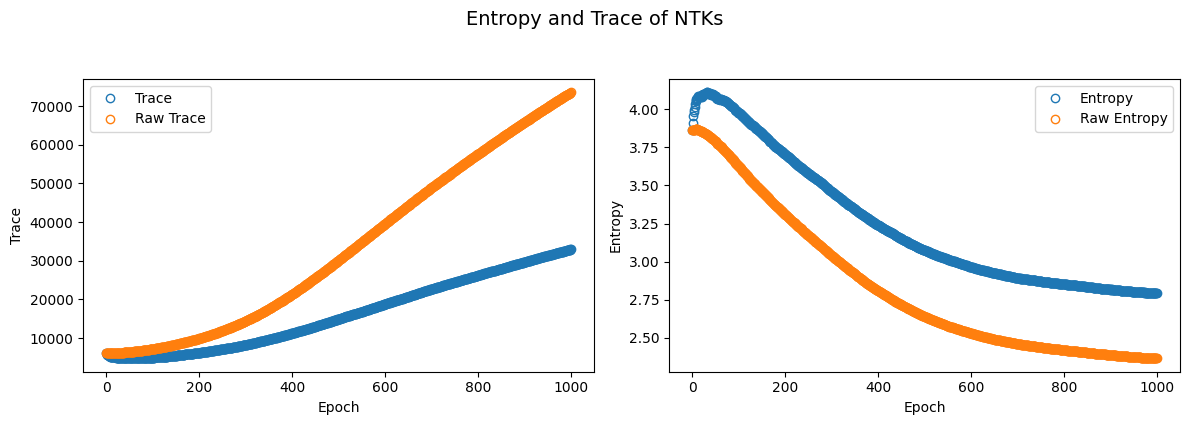

In [20]:
unrotated_ntk_sequence = np.array(unrotated_ntk_sequence)
traced_ntk_sequence = np.array([np.trace(ntk) for ntk in unrotated_ntk_sequence])

fig, axs = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)

axs[0].plot(traced_ntk_sequence, 'o', mfc='None', label="Trace")
axs[0].plot(np.array([np.trace(ntk) for ntk in train_report.ntk]), 'o', mfc='None', label="Raw Trace")
# axs[0].set_yscale('log')

# Calculate the entropy of the unrotated NTKs
entropies = []
for ntk in unrotated_ntk_sequence:
    calculator = EntropyAnalysis(matrix=ntk)
    entropy = calculator.compute_von_neumann_entropy(
        effective=False, normalize_eig=True
    )
    entropies.append(entropy)

axs[1].plot(entropies, 'o', mfc='None', label="Entropy")
axs[1].plot(train_report.entropy, 'o', mfc='None', label="Raw Entropy")

axs[0].set_xlabel("Epoch")
axs[1].set_xlabel("Epoch")
axs[0].set_ylabel("Trace")
axs[1].set_ylabel("Entropy")
axs[0].legend()
axs[1].legend()
# Set title in the middle of the figure
fig.suptitle("Entropy and Trace of NTKs", y=1.05, fontsize=14)

# Calculate rotation in the NTK

As the NTK is a gram matrix, i.e. it is positive semi-definite, the rotation part of the 
decomposition will be a unit matrix. 
Such a marix cannot rotate. 

/tikhome/knikolaou/miniconda3/envs/jax_gpu/lib/python3.10/site-packages/jax/_src/array.py:363: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype)


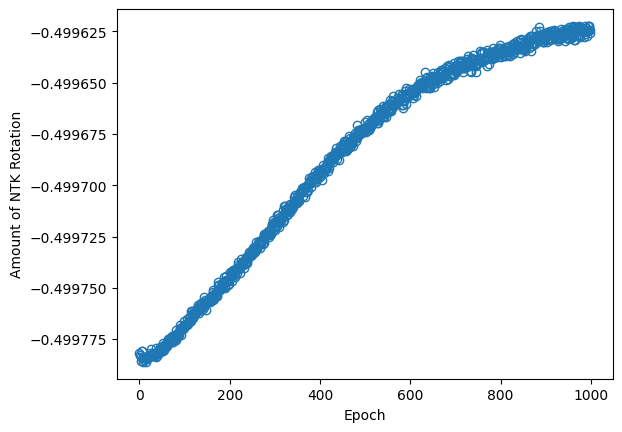

In [21]:
ntk_s = train_report.ntk
# Calculate polar decomposition of each NTK
ntk_polar = np.array([polar(ntk) for ntk in ntk_s])
# Take the rotation matrix from each polar decomposition
ntk_rotation = np.array([p[0] for p in ntk_polar])
# Calculate the eigenvalues of each rotation matrix
ntk_rotation_eigvals = np.array([onp.linalg.eig(p)[0] for p in ntk_rotation])
# Calculate the angle of each eigenvalue
ntk_rotation_angles = np.array([(np.arccos(i) - 1) / 2 for i in ntk_rotation_eigvals])
# Calculate the mean angle of each NTK
ntk_rotation_mean = np.array([np.mean(p) for p in ntk_rotation_angles])

plt.plot(
    ntk_rotation_mean, 
    'o', 
    mfc='None', 
)
plt.xlabel("Epoch")
plt.ylabel("Amount of NTK Rotation")

plt.show()

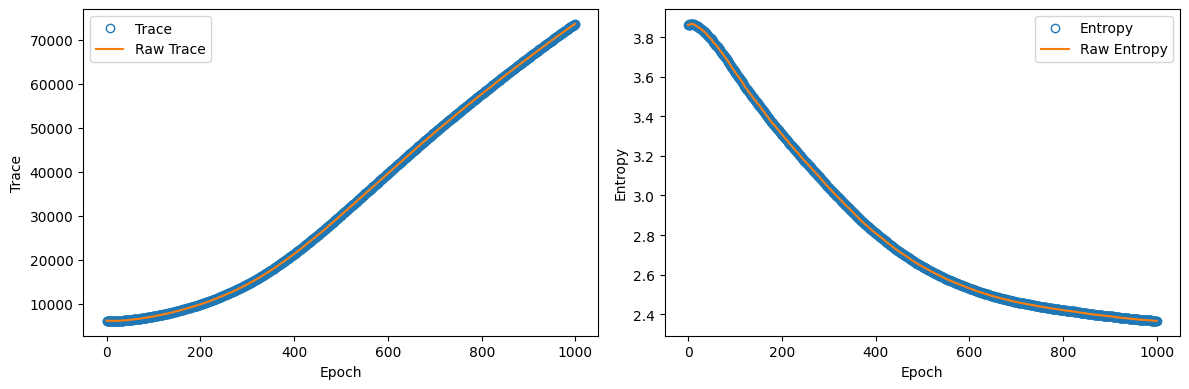

In [22]:
stretch_trace = []
stretch_entropy = []

for s in ntk_polar[:, 1, :, :]:
    stretch_trace.append(np.trace(s))
    calculator = EntropyAnalysis(matrix=s)
    entropy = calculator.compute_von_neumann_entropy(
        effective=False, normalize_eig=True
    )
    stretch_entropy.append(entropy)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)

axs[0].plot(stretch_trace, 'o', mfc='None', label="Trace")
axs[0].plot(train_report.trace, '-', mfc='None', label="Raw Trace")

axs[1].plot(stretch_entropy, 'o', mfc='None', label="Entropy")
axs[1].plot(train_report.entropy, '-', mfc='None', label="Raw Entropy")

axs[0].set_xlabel("Epoch")
axs[1].set_xlabel("Epoch")
axs[0].set_ylabel("Trace")
axs[1].set_ylabel("Entropy")
axs[0].legend()
axs[1].legend()



In [23]:
# ntk_rot_eigspace = np.array([onp.linalg.eig(p[0])[1] for p in ntk_polar])
# ntk_rot_eigvals = np.array([onp.linalg.eig(p[0])[0] for p in ntk_polar])

ntk_rot_eigvals = []
ntk_rot_eigspace = []

for ntk in train_report.ntk:
    u, _ = jax.scipy.linalg.polar(ntk)
    eigvals, eigvects = onp.linalg.eig(u)
    ntk_rot_eigvals.append(eigvals)
    ntk_rot_eigspace.append(eigvects)

ntk_rot_eigvals = np.array(ntk_rot_eigvals)
ntk_rot_eigspace = np.array(ntk_rot_eigspace)


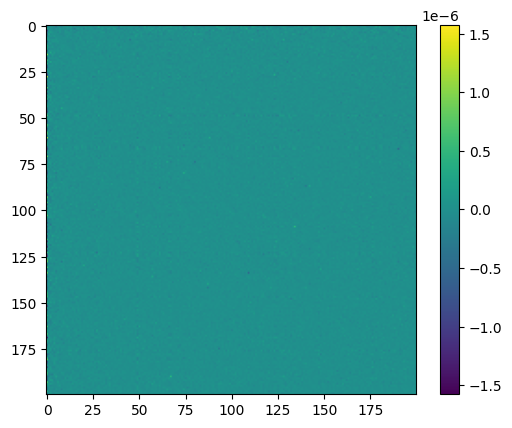

In [24]:
plt.imshow(ntk_rotation[199] - ntk_rotation[0])
# colorbar
plt.colorbar()

In [25]:
# # Take the indices of the 5 largest eigenvalues
# indices = np.array([np.argsort(ntk_rot_eigvals[i])[-5:] for i in range(len(ntk_rot_eigvals))])
# # Take the corresponding eigenvectors
# eigenvectors = np.array([ntk_rot_eigspace[i][indices[i]] for i in range(len(ntk_rot_eigspace))])


# # Plot surface of eigenvector values in as 3d plot in matplotlib
# count_of_eigenvector = np.abs(eigenvectors).sum(axis=1)[:300, :].T
# print(count_of_eigenvector.shape)

# fig = plt.figure(tight_layout=True)
# ax = fig.add_subplot(111, projection='3d')
# X, Y = np.meshgrid(np.arange(0, 300), np.arange(0, 200))
# ax.plot_surface(X, Y, count_of_eigenvector, cmap='viridis')
# # change angle of view
# ax.view_init(azim=50, elev=20)
# ax.set_xlabel("Epoch")
# ax.set_ylabel("Input Data")
# ax.set_zlabel("Count of Eigenvalue")

In [26]:
# n = 4

# # Take the indices of the N largest eigenvalues
# indices = np.array([np.argsort(ntk_rot_eigvals[i])[-n:] for i in range(len(ntk_rot_eigvals))])
# # Take the corresponding eigenvectors
# eigenvectors = np.array([ntk_rot_eigspace[i][indices[i]] for i in range(len(ntk_rot_eigspace))])


# # Calculate the entropy of the the rate of how often certain images are represented in the eigenvectors
# entropy_of_eigenvector = []

# def shannon_entropy(p):
#     return -np.sum(p * np.log(p))


# count_of_eigenvector = np.abs(eigenvectors).sum(axis=1)

# for vector in count_of_eigenvector:
#     entropy_of_eigenvector.append(shannon_entropy(vector / vector.sum()))

# plt.plot(entropy_of_eigenvector, 'o', mfc='None')
# plt.title(rf"Entropy of ${n}$ most invariant Eigenvectors")
# plt.xlabel("Epoch")
# plt.ylabel("Entropy")

# plt.show()

In [27]:
# # The result is probably only due to the recursive implementation 

# # Calulate the total rotation of the data
# ntk_rotation_total = [ntk_rotation[0]]
# for rotation in ntk_rotation[1:]:
#     ntk_rotation_total.append(np.dot(ntk_rotation_total[-1], rotation))

# ntk_rotation_total_eigvals = np.array([onp.linalg.eig(p)[0] for p in ntk_rotation_total])
# ntk_rotation_total_angles = np.array([(np.arccos(i) - 1) / 2 for i in ntk_rotation_total_eigvals])
# ntk_rotation_total_mean = np.array([np.mean(p) for p in ntk_rotation_total_angles])

# plt.plot(
#     ntk_rotation_total_mean, 
#     'o', 
#     mfc='None', 
# )
# plt.xlabel("Epoch")
# plt.ylabel("Amount of NTK Rotation")


In [28]:
# Calculate the entropy of the unrotated data

# Calculate the inverse of the rotation matrix
ntk_rotation_inv = np.array([np.linalg.inv(p) for p in ntk_rotation])
# Unrotate each NTK by multiplying it with the inverse of all rotation matrices before it
ntk_unrotated = copy.deepcopy(ntk_s)
for i in range(len(ntk_unrotated)-1):
    for j in range(i):
        ntk_unrotated[i+1] = np.dot(ntk_unrotated[i+1], ntk_rotation_inv[j])

# Calculate the trace of the unrotated NTKs
traced_ntk_unrotated = np.array([np.trace(ntk) for ntk in ntk_unrotated])

# Calculate the entropy of the unrotated NTKs
entropies = []
for ntk in ntk_unrotated:
    calculator = EntropyAnalysis(matrix=ntk)
    entropy = calculator.compute_von_neumann_entropy(
        effective=False, normalize_eig=True
    )
    entropies.append(entropy)

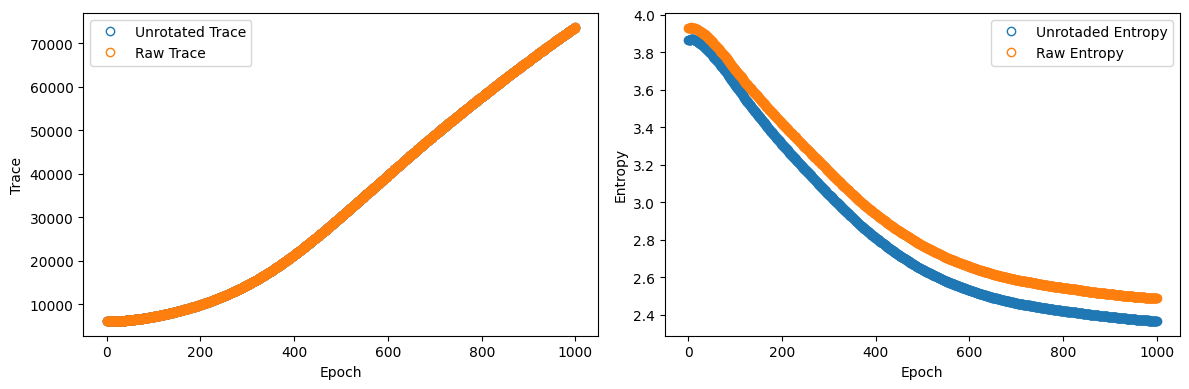

In [29]:
# Plot the results
fig, axs = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)

axs[0].plot(traced_ntk_unrotated, 'o', mfc='None', label="Unrotated Trace")
axs[1].plot(entropies, 'o', mfc='None', label="Unrotaded Entropy")

# Compare to the original NTKs
axs[0].plot(train_report.trace, 'o', mfc='None', label="Raw Trace")
axs[1].plot(train_report.covariance_entropy, 'o', mfc='None', label="Raw Entropy")


axs[0].set_xlabel("Epoch")
axs[1].set_xlabel("Epoch")
axs[0].set_ylabel("Trace")
axs[1].set_ylabel("Entropy")
axs[0].legend()
axs[1].legend()


# Mind Drift Collective Variable

Entropy and Trace of the NTK are two collective variables (CVs) that quantify the 
distribution of eigenvalues of the NTK.

The State Drift (a new CV) quantifies the drift of the NTK matrix during training.

In [30]:
# compute relative drift to the next NTK
ntk_sequence = train_report.covariance_ntk
ntk_sequence = np.array([ntk / np.trace(ntk) for ntk in ntk_sequence])

# Calculate the dotproduct of the first NTK with each NTK
ntk_0 = ntk_sequence[0]
ntk_sequence_drift = np.array([np.dot(ntk_0, ntk) for ntk in ntk_sequence])

# # Calculate the dotproduct of subsequent NTKs
# ntk_sequence_drift = np.array([np.dot(ntk_sequence_drift[i], ntk_sequence_drift[i+1]) for i in range(len(ntk_sequence)-1)])

In [31]:
diag_norms = np.array([np.mean(np.diag(ntk)**2) for ntk in ntk_sequence_drift])
off_diag_norms = np.array([ np.mean( np.tril(ntk, k=-1) ** 2 ) for ntk in ntk_sequence_drift])

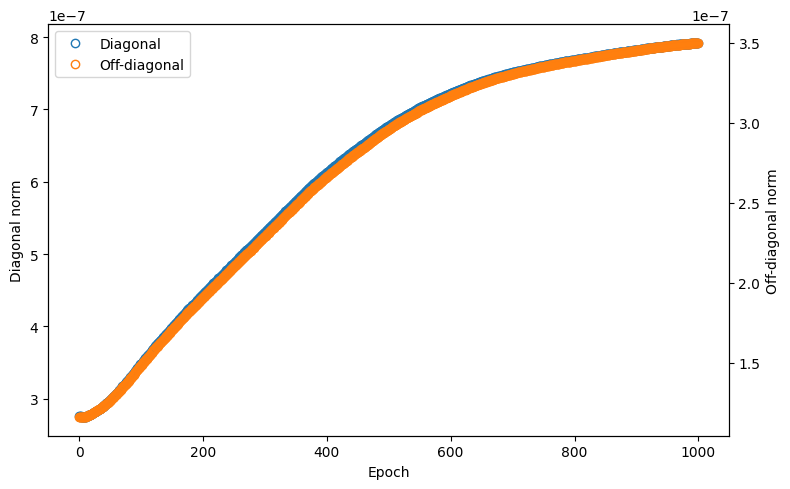

In [32]:
# Plot twinx figure
fig, ax1 = plt.subplots(figsize=(8, 5), tight_layout=True)
ax1.plot(diag_norms, 'o', mfc='None', label="Diagonal")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Diagonal norm")

ax2 = ax1.twinx()
ax2.plot(off_diag_norms, 'o', mfc='None', label="Off-diagonal", color="C1")
ax2.set_ylabel("Off-diagonal norm")

# one legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.show()


/tmp/ipykernel_1542476/3778113225.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm)


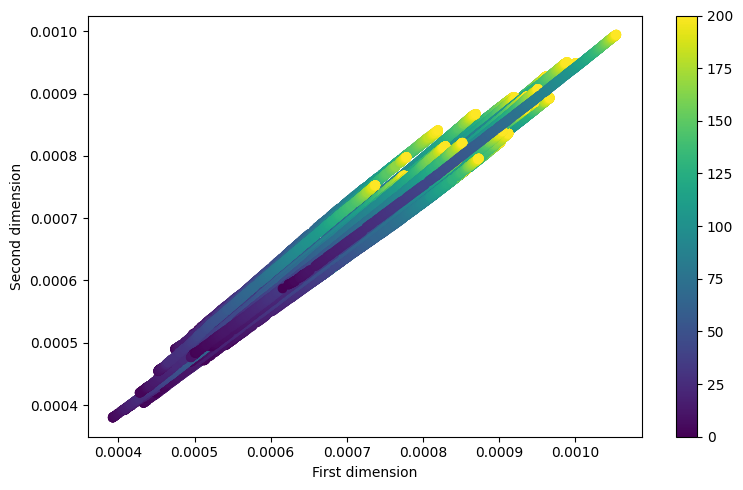

In [33]:
# Plot the first two dimensions of the first n vectors of the NTK

sub_ntk = [ntk[:50, :50] for ntk in ntk_sequence_drift]
sub_ntk = np.array(sub_ntk)

# for each point, encode the proceeding NTK by color
colors = np.arange(len(sub_ntk))

fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
for i in range(50):
    ax.scatter(sub_ntk[:, 0, i], sub_ntk[:, 1, i], c=colors, cmap="viridis")

# Plot colorbar
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0, vmax=200))
sm.set_array(colors)
fig.colorbar(sm)

ax.set_xlabel("First dimension")
ax.set_ylabel("Second dimension")
# ax.set_yscale("log")
# ax.set_xscale("log")
plt.show()



### All Plots

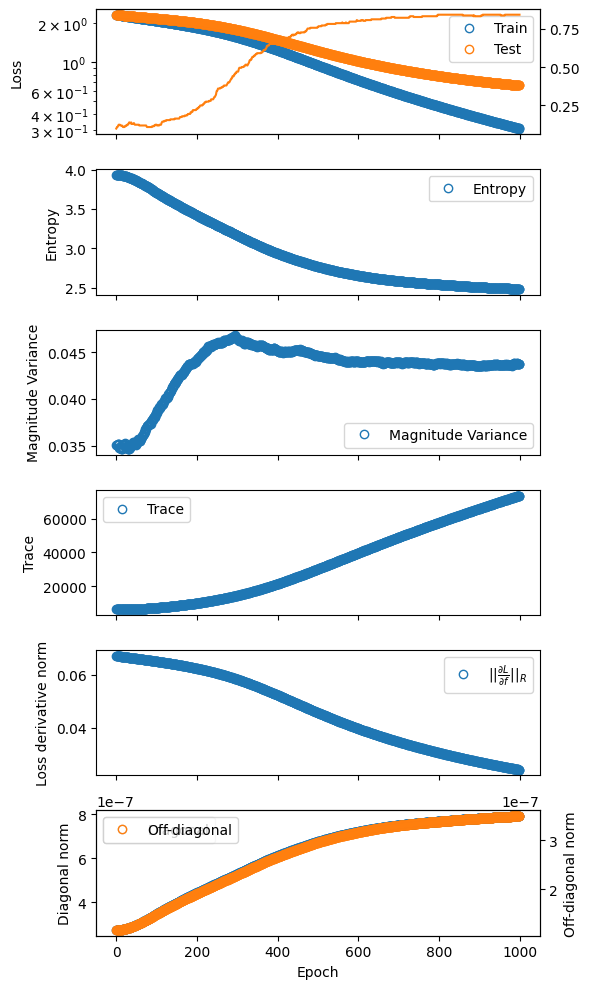

In [34]:
# Plot all quantities in one figure below each other 
fig, axs = plt.subplots(6, 1, figsize=(6, 10), sharex=True, tight_layout=True)

axs[0].plot(train_report.loss, 'o', mfc='None', label="Train")
axs[0].plot(test_report.loss, 'o', mfc='None', label="Test")
axs1 = axs[0].twinx()
axs1.plot(test_report.accuracy, '-', mfc='None', label="Test Accuracy", color="C1")
# axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_yscale("log")
axs[0].legend()

axs[1].plot(train_report.covariance_entropy, 'o', mfc='None', label="Entropy")
# axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Entropy")
axs[1].legend()

axs[2].plot(train_report.magnitude_variance, 'o', mfc='None', label="Magnitude Variance")
# axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Magnitude Variance")
axs[2].legend()

axs[3].plot(train_report.trace, 'o', mfc='None', label="Trace")
# axs[3].set_xlabel("Epoch")
axs[3].set_ylabel("Trace")
axs[3].legend()

axs[4].plot(
    train_report.loss_derivative, 
    'o', 
    mfc='None', 
    label=r"$|| \frac{\partial L }{ \partial f}||_R$"
)
# axs[4].set_xlabel("Epoch")
axs[4].set_ylabel("Loss derivative norm")
axs[4].legend()

axs[5].plot(diag_norms, 'o', mfc='None', label="Diagonal")
axs[5].set_xlabel("Epoch")
axs[5].set_ylabel("Diagonal norm")
axs[5].legend()

# TWINX
ax2 = axs[5].twinx()
ax2.plot(off_diag_norms, 'o', mfc='None', label="Off-diagonal", color="C1")
ax2.set_ylabel("Off-diagonal norm")
ax2.legend()


plt.show()




# Rotation of mean eigvector

In [46]:
# Calculate the mean eigenvector of each NTK and scale it by the corresponding eigenvalue
ntk_mean_eigenvector = []
first_n_eigenvectors = []

for ntk in train_report.ntk:
    eigvals, eigvects = onp.linalg.eig(ntk)
    scaled_eigenvectors = eigvects * eigvals
    # mean_eigenvector = np.abs(np.mean(scaled_eigenvectors, axis=0))
    mean_eigenvector = np.mean(scaled_eigenvectors, axis=0)
    ntk_mean_eigenvector.append(mean_eigenvector)

    first_n_eigenvector = scaled_eigenvectors[:, :10]
    first_n_eigenvectors.append(first_n_eigenvector)

ntk_mean_eigenvector = np.array(ntk_mean_eigenvector)
first_n_eigenvectors = np.array(first_n_eigenvectors)

(0.0, 5.0)

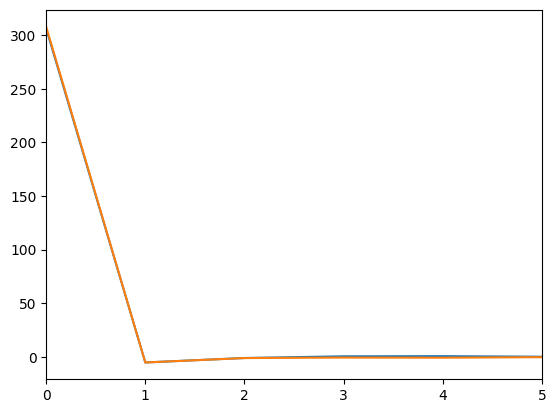

In [36]:
plt.plot(ntk_mean_eigenvector[216])
plt.plot(ntk_mean_eigenvector[217])
# change x range
plt.xlim(0, 5)
# ntk_mean_eigenvector[216], ntk_mean_eigenvector[217]

In [61]:
# Evaluate the similarity of the mean eigenvectors
mean_eigenvector_similarity = np.array([np.dot(ntk_mean_eigenvector[0], vec) / np.linalg.norm(ntk_mean_eigenvector[0]) / np.linalg.norm(vec) for vec in ntk_mean_eigenvector])

# Calculate the angle between the mean eigenvectors
# mean_eigenvector_similarity = np.array([np.dot(ntk_mean_eigenvector[i], ntk_mean_eigenvector[i+1]) /  np.linalg.norm(ntk_mean_eigenvector[i]) / np.linalg.norm(ntk_mean_eigenvector[i+1]) for i in range(len(ntk_mean_eigenvector)-1)])

# Calculate the similarity of the first n first_n_eigenvector
comparison = np.ones_like(first_n_eigenvectors[0])
print(comparison.shape)
first_n_eigenvectors_similarity = np.array([np.dot(comparison.T, first_n_eigenvectors[i]) / np.linalg.norm(comparison) / np.linalg.norm(first_n_eigenvectors[i]) for i in range(len(first_n_eigenvectors))])

(200, 10)


Text(0, 0.5, 'Similarity of eigenvectors')

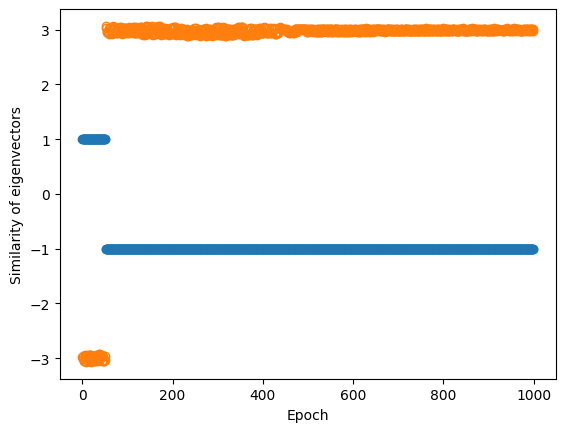

In [62]:
plt.plot(mean_eigenvector_similarity, 'o', mfc='None')
plt.plot(np.sum(first_n_eigenvectors_similarity, axis=(1, 2)), 'o', mfc='None')
plt.xlabel("Epoch")
plt.ylabel("Similarity of eigenvectors")
